In [ ]:
try:
    import pyro
except:
    ! pip install pyro-ppl
    ! pip install Biopython

     |████████████████████████████████| 718 kB 4.0 MB/s 
     |████████████████████████████████| 2.3 MB 4.1 MB/s 


## Prepare

In [ ]:
import numpy as np
from tqdm import tqdm
from Bio import Phylo

In [ ]:
leaf_seq_path = "/content/realign_MSA.fas"
tree_path = "/content/_True_Rooted_tree_node_labels.tre"

## Latent Tree

In [ ]:
import pyro
import torch
from helper import *
from PyroModel import *
from JAXFunctions import *
from Error_measure import *
from torch.optim import Adam
from tqdm import tqdm
import matplotlib.pyplot as plt
from pyro.infer import SVI, Trace_ELBO
from sklearn.manifold import TSNE
from scipy.stats import spearmanr, pearsonr
import os
import re

from ASR import ASR

from sklearn.svm import SVC, SVR
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPRegressor

import pickle
import math

In [ ]:
os.environ["XLA_PYTHON_CLIENT_ALLOCATOR"] = "platform"

In [ ]:
AA_dict, back_AA_dict = get_AA_dict(n_c=24)
S_all, S_names_all, S_length_all, S_char_all = load_Unaligned_Data(leaf_seq_path, "cuda", AA_dict)

In [ ]:
# true_tree_distances_including_ancestors = get_true_tree_distances_including_ancestors(tree_path, S_names, Anc_names)
# true_tree_distances = true_tree_distances_including_ancestors[:len(S_names), :len(S_names)]

import pickle

# with open("matrix.txt", "wb") as f:
#     pickle.dump(true_tree_distances_including_ancestors, f)
with open("matrix.txt", "rb") as f:
    true_tree_distances_including_ancestors = pickle.load(f)
true_tree_distances = true_tree_distances_including_ancestors[:len(S_names_all), :len(S_names_all)]

In [ ]:
np.random.seed(42)
inds = np.random.choice(S_all.shape[0], S_all.shape[0], False)
train_idx = inds[:int(S_all.shape[0] * 0.7)]
test_idx = inds[int(S_all.shape[0] * 0.7):]

S_train, S_names_train, S_length_train, S_char_train = S_all[train_idx], np.array(S_names_all)[train_idx].tolist(), np.array(S_length_all)[train_idx].tolist(), np.array(S_char_all)[train_idx].tolist()
S_test, S_names_test, S_length_test, S_char_test = S_all[test_idx], np.array(S_names_all)[test_idx].tolist(), np.array(S_length_all)[test_idx].tolist(), np.array(S_char_all)[test_idx].tolist(),

In [ ]:
msa_ref = nn.Softmax(-1)(torch.randn(int(S_train.shape[1] * 1.5), 23, device="cuda"))

In [ ]:
pyro.clear_param_store()
vae = VAE(50, 24, msa_ref.shape[0])
def per_param_callable(module_name, param_name):
    if param_name in ["tree_embed_loc", "tree_embed_len"]:
        return {"lr": 0.01, "clip_norm": 10}
    elif param_name in ["Blosum"]:
        return {"lr": 1e-8, "clip_norm": 10}
    else:   
        return {"lr": 0.001, "clip_norm": 10}
optimizer = pyro.optim.ClippedAdam(per_param_callable)
svi = SVI(vae.batched_model_latent_tree, vae.batched_guide_latent_tree, optimizer, loss=Trace_ELBO(num_particles=1))

In [ ]:
ELBOs = []
Rec_Acc = []
Rec_Acc_remove_gap = []

train_corr = []
test_corr = []


S_ave_pos = []

In [ ]:
true_tree_distances_train = true_tree_distances[:, [S_names_all.index(i) for i in S_names_train]][[S_names_all.index(i) for i in S_names_train], :]
true_tree_distances_test = true_tree_distances[:, [S_names_all.index(i) for i in S_names_test]][[S_names_all.index(i) for i in S_names_test], :]

In [ ]:
batch_size = 32

In [ ]:
for b in tqdm(range(1001)):
    batch_size = 32
    indices = np.random.choice(S_train.shape[0], S_train.shape[0], False)
    elbos = []
    for batch in range(S_train.shape[0] // batch_size - 1):
      batch_idx = indices[batch * batch_size: batch * batch_size + batch_size]
      back_idx = indices[S_train.shape[0] // batch_size * batch_size - batch_size:]
      all_idx = np.concatenate([back_idx, batch_idx])

      elbo = svi.step(Unaligned_S=S_train[batch_idx],
               S_length=np.array(S_length_train)[batch_idx].tolist(),
               S_index=batch_idx,
               msa_ref=msa_ref,
               S_ave_pos=S_ave_pos,
               num_batch=S_train.shape[0] // batch_size - 1,
               Unaligned_S_back=S_train[back_idx],
               S_back_length=np.array(S_length_train)[back_idx].tolist(),
               S_back_index=back_idx,
               num_instance=S_train.shape[0],
               tree_emb_dim=100,
               regularization_D=False)
      elbos.append(elbo)
    ELBOs.append(sum(elbos) / len(elbos))

    msa_ref_epoch = torch.cat(S_ave_pos, dim=0).sum(dim=0) + 1e-3
    msa_ref_epoch /= msa_ref_epoch.sum(-1, True)

    msa_ref = msa_ref_epoch * 0.05 + msa_ref * 0.95
    S_ave_pos = [] # clear


    if b == 400:
        def per_param_callable(module_name, param_name):
            if param_name in ["tree_embed_loc", "tree_embed_len"]:
                return {"lr": 1e-6, "clip_norm": 10}
            elif param_name in ["sigma_f_loc", "sigma_n_loc", "lambd_loc"]:
                return {"lr": 1e-5, "clip_norm": 10}
            else:
                return {"lr": 0.001, "clip_norm": 10}
        optimizer = pyro.optim.ClippedAdam(per_param_callable)
        svi = SVI(vae.batched_model_latent_tree, vae.batched_guide_latent_tree, optimizer, loss=Trace_ELBO(num_particles=1))

    if b % 10 == 0:
        with torch.no_grad():
            # Rec ACC
            S_onehot = torch.zeros_like(S_train[:, :, None]).expand([-1, -1, 24]).clone().scatter_(-1, S_train[:, :, None], 1).float().cuda()
            MSA = S_onehot[:, :, :].float().cuda()

            ref_emb = msa_ref
            mask = (torch.arange(S_train.shape[1])[None, :] < torch.tensor(S_length_train)[:, None]).to(vae.device)
            s_emb = (S_onehot * mask[:, :, None])[:, :, :-1]

            MSA = []
            re_MSA = []
            for i in range(int(math.ceil(S_train.shape[0] / batch_size))):
                similar_tensor = ref_emb @ pyro.param("Blosum").detach() @ s_emb[i * batch_size: (i + 1) * batch_size].transpose(1, 2)
                path = snw(similar_tensor, list(S_length_train)[i * batch_size: (i + 1) * batch_size], vae.nw_fn)
                _MSA = path @ S_onehot[i * batch_size: (i + 1) * batch_size] # N, L, l @ N, l, n_c
                _MSA[:, :, -1] = _MSA[:, :, -1] + 1 - path.sum(-1)  # fill the gaps with onehot-encoding of "-"
                Z_loc = vae.encoder(_MSA, None).detach()
                _re_MSA = vae.decoder.forward(None, Z_loc, False)
                MSA.append(_MSA)
                re_MSA.append(_re_MSA)
            MSA = torch.cat(MSA, dim=0)
            re_MSA = torch.cat(re_MSA, dim=0)

            re_MSA_str = tensor2char(re_MSA, back_AA_dict)
            MSA_str = tensor2char(S_onehot, back_AA_dict)

            Rec_Acc.append(np.mean(asr_accuracy(re_MSA_str, MSA_str)))


            # Distances Correlation
            S_onehot = torch.zeros_like(S_train[:, :, None]).expand([-1, -1, 24]).clone().scatter_(-1, S_train[:, :, None], 1).float().cuda()
            MSA = S_onehot[:, :, :].float().cuda()

            ref_emb = msa_ref
            mask = (torch.arange(S_train.shape[1])[None, :] < torch.tensor(S_length_train)[:, None]).to(vae.device)
            s_emb = (S_onehot * mask[:, :, None])[:, :, :-1]
            
            path = []
            for i in range(int(math.ceil(S_train.shape[0] / batch_size))):
                similar_tensor = ref_emb @ pyro.param("Blosum").detach() @ s_emb[i * batch_size: (i + 1) * batch_size].transpose(1, 2)
                path.append(
                    snw(similar_tensor, list(S_length_train)[i * batch_size: (i + 1) * batch_size], vae.nw_fn).detach()
                )
            path = torch.cat(path, dim=0)
            MSA = path @ S_onehot # N, L, l @ N, l, n_c


            MSA[:, :, -1] = MSA[:, :, -1] + 1 - path.sum(-1)  # fill the gaps with onehot-encoding of "-"
            Z_loc = vae.encoder(MSA, None).detach()
            latent_distance = 1 - torch.sum(Z_loc[None, :, :] * Z_loc[:, None, :], dim=-1) / torch.norm(Z_loc, p=2, dim=-1)[None, :] / torch.norm(Z_loc, p=2, dim=-1)[:, None]
            latent_distance_upper = latent_distance[torch.triu_indices(S_train.shape[0], S_train.shape[0], 1)[0], torch.triu_indices(S_train.shape[0], S_train.shape[0], 1)[1]]
            real_distance_upper = true_tree_distances_train[torch.triu_indices(S_train.shape[0], S_train.shape[0], 1)[0], torch.triu_indices(S_train.shape[0], S_train.shape[0], 1)[1]]
            train_corr.append(spearmanr(latent_distance_upper.cpu(), real_distance_upper)[0])



            S_onehot = torch.zeros_like(S_test[:, :, None]).expand([-1, -1, 24]).clone().scatter_(-1, S_test[:, :, None], 1).float().cuda()
            MSA = S_onehot[:, :, :].float().cuda()

            ref_emb = msa_ref
            mask = (torch.arange(S_test.shape[1])[None, :] < torch.tensor(S_length_test)[:, None]).to(vae.device)
            s_emb = (S_onehot * mask[:, :, None])[:, :, :-1]


            path = []
            for i in range(int(math.ceil(S_test.shape[0] / batch_size))):
                similar_tensor = ref_emb @ pyro.param("Blosum").detach() @ s_emb[i * batch_size: (i + 1) * batch_size].transpose(1, 2)
                path.append(
                    snw(similar_tensor, list(S_length_test)[i * batch_size: (i + 1) * batch_size], vae.nw_fn)
                )
            path = torch.cat(path, dim=0)
            MSA = path @ S_onehot # N, L, l @ N, l, n_c

            MSA[:, :, -1] = MSA[:, :, -1] + 1 - path.sum(-1)  # fill the gaps with onehot-encoding of "-"
            Z_loc = vae.encoder(MSA, None).detach()
            latent_distance = 1 - torch.sum(Z_loc[None, :, :] * Z_loc[:, None, :], dim=-1) / torch.norm(Z_loc, p=2, dim=-1)[None, :] / torch.norm(Z_loc, p=2, dim=-1)[:, None]
            latent_distance_upper = latent_distance[torch.triu_indices(S_test.shape[0], S_test.shape[0], 1)[0], torch.triu_indices(S_test.shape[0], S_test.shape[0], 1)[1]]
            real_distance_upper = true_tree_distances_test[torch.triu_indices(S_test.shape[0], S_test.shape[0], 1)[0], torch.triu_indices(S_test.shape[0], S_test.shape[0], 1)[1]]
            test_corr.append(spearmanr(latent_distance_upper.cpu(), real_distance_upper)[0])


  0%|          | 0/1001 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/distributions/dirichlet.py:71: UserWarning: Specified kernel cache directory could not be created! This disables kernel caching. Specified directory is /root/.cache/torch/kernels. This warning will appear only once per process. (Triggered internally at  ../aten/src/ATen/native/cuda/jit_utils.cpp:860.)
  torch.lgamma(self.concentration.sum(-1)) -
100%|██████████| 1001/1001 [4:38:45<00:00, 16.71s/it]


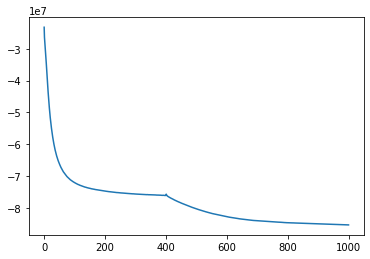

In [ ]:
plt.rcParams["figure.figsize"] = (6, 4)
plt.plot(ELBOs)

([<matplotlib.axis.YTick at 0x7fe897eaed50>,
 <a list of 11 Text major ticklabel objects>)

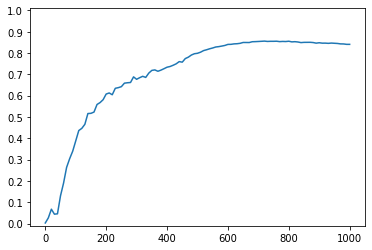

In [ ]:
plt.rcParams["figure.figsize"] = (6, 4)
plt.plot(np.arange(len(Rec_Acc)) * 10, Rec_Acc)
plt.ylim(-0.01, 1.01)
plt.yticks(np.arange(0, 1.01, 0.1))

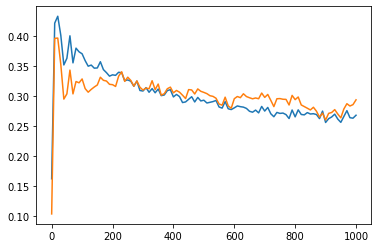

In [ ]:
plt.rcParams["figure.figsize"] = (6, 4)
plt.plot(np.arange(len(train_corr)) * 10, train_corr)
plt.plot(np.arange(len(test_corr)) * 10, test_corr)
plt.show()

spearmanr:  0.267991133796032
pearson:  0.48398903759913064


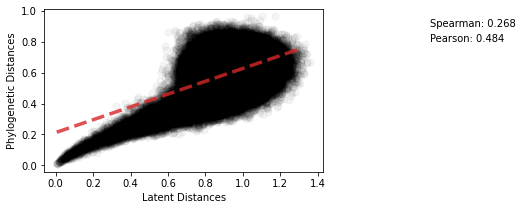

In [ ]:


# Distances Correlation
S_onehot = torch.zeros_like(S_train[:, :, None]).expand([-1, -1, 24]).clone().scatter_(-1, S_train[:, :, None], 1).float().cuda()
MSA = S_onehot[:, :, :].float().cuda()

ref_emb = msa_ref
mask = (torch.arange(S_train.shape[1])[None, :] < torch.tensor(S_length_train)[:, None]).to(vae.device)
s_emb = (S_onehot * mask[:, :, None])[:, :, :-1]

path = []
for i in range(int(math.ceil(S_train.shape[0] / batch_size))):
    similar_tensor = ref_emb @ pyro.param("Blosum").detach() @ s_emb[i * batch_size: (i + 1) * batch_size].transpose(1, 2)
    path.append(
        snw(similar_tensor, list(S_length_train)[i * batch_size: (i + 1) * batch_size], vae.nw_fn).detach()
    )
path = torch.cat(path, dim=0)
MSA = path @ S_onehot # N, L, l @ N, l, n_c


MSA[:, :, -1] = MSA[:, :, -1] + 1 - path.sum(-1)  # fill the gaps with onehot-encoding of "-"
Z_loc = vae.encoder(MSA, None).detach()
latent_distance = 1 - torch.sum(Z_loc[None, :, :] * Z_loc[:, None, :], dim=-1) / torch.norm(Z_loc, p=2, dim=-1)[None, :] / torch.norm(Z_loc, p=2, dim=-1)[:, None]
latent_distance_upper = latent_distance[torch.triu_indices(S_train.shape[0], S_train.shape[0], 1)[0], torch.triu_indices(S_train.shape[0], S_train.shape[0], 1)[1]]
real_distance_upper = true_tree_distances_train[torch.triu_indices(S_train.shape[0], S_train.shape[0], 1)[0], torch.triu_indices(S_train.shape[0], S_train.shape[0], 1)[1]]

print("spearmanr: ", spearmanr(latent_distance_upper.cpu(), real_distance_upper)[0])
print("pearson: ", pearsonr(latent_distance_upper.cpu(), real_distance_upper)[0])

parameter = np.polyfit(latent_distance_upper.cpu(), real_distance_upper, 1)
x = np.arange(min(latent_distance_upper.cpu()), max(latent_distance_upper.cpu()), 0.1)
y = parameter[0] * x + parameter[1]

plt.rcParams["figure.figsize"] = (5, 3)
plt.xlabel("Latent Distances")
plt.ylabel("Phylogenetic Distances")
plt.text(2, 0.9, "Spearman: %.3f"% spearmanr(latent_distance_upper.cpu(), real_distance_upper)[0])
plt.text(2, 0.8, "Pearson: %.3f"% pearsonr(latent_distance_upper.cpu(), real_distance_upper)[0])
plt.scatter(latent_distance_upper.cpu(), real_distance_upper, alpha=0.04, s=50, color="black")
# plt.xlim(0, 5.5)
# plt.ylim(-0.5, 4.0)
plt.plot(x, y, color="tab:red", linewidth=3.5, alpha=0.8, linestyle="--")

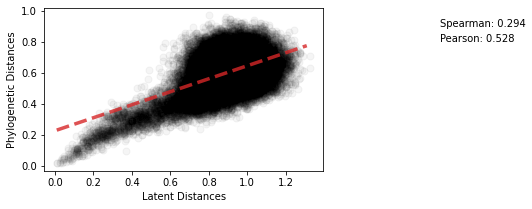

In [ ]:

S_onehot = torch.zeros_like(S_test[:, :, None]).expand([-1, -1, 24]).clone().scatter_(-1, S_test[:, :, None], 1).float().cuda()
MSA = S_onehot[:, :, :].float().cuda()

ref_emb = msa_ref
mask = (torch.arange(S_test.shape[1])[None, :] < torch.tensor(S_length_test)[:, None]).to(vae.device)
s_emb = (S_onehot * mask[:, :, None])[:, :, :-1]


path = []
for i in range(int(math.ceil(S_test.shape[0] / batch_size))):
    similar_tensor = ref_emb @ pyro.param("Blosum").detach() @ s_emb[i * batch_size: (i + 1) * batch_size].transpose(1, 2)
    path.append(
        snw(similar_tensor, list(S_length_test)[i * batch_size: (i + 1) * batch_size], vae.nw_fn)
    )
path = torch.cat(path, dim=0)
MSA = path @ S_onehot # N, L, l @ N, l, n_c

MSA[:, :, -1] = MSA[:, :, -1] + 1 - path.sum(-1)  # fill the gaps with onehot-encoding of "-"
Z_loc = vae.encoder(MSA, None).detach()
latent_distance = 1 - torch.sum(Z_loc[None, :, :] * Z_loc[:, None, :], dim=-1) / torch.norm(Z_loc, p=2, dim=-1)[None, :] / torch.norm(Z_loc, p=2, dim=-1)[:, None]
latent_distance_upper = latent_distance[torch.triu_indices(S_test.shape[0], S_test.shape[0], 1)[0], torch.triu_indices(S_test.shape[0], S_test.shape[0], 1)[1]]
real_distance_upper = true_tree_distances_test[torch.triu_indices(S_test.shape[0], S_test.shape[0], 1)[0], torch.triu_indices(S_test.shape[0], S_test.shape[0], 1)[1]]


parameter = np.polyfit(latent_distance_upper.cpu(), real_distance_upper, 1)
x = np.arange(min(latent_distance_upper.cpu()), max(latent_distance_upper.cpu()), 0.1)
y = parameter[0] * x + parameter[1]

plt.rcParams["figure.figsize"] = (5, 3)
plt.xlabel("Latent Distances")
plt.ylabel("Phylogenetic Distances")
plt.text(2, 0.9, "Spearman: %.3f"% spearmanr(latent_distance_upper.cpu(), real_distance_upper)[0])
plt.text(2, 0.8, "Pearson: %.3f"% pearsonr(latent_distance_upper.cpu(), real_distance_upper)[0])
plt.scatter(latent_distance_upper.cpu(), real_distance_upper, alpha=0.04, s=50, color="black")

# plt.xticks([0, 1, 2, 3, 4])
plt.plot(x, y, color="tab:red", linewidth=3.5, alpha=.8, linestyle="--")


In [ ]:
pyro.param("sigma_f_loc"), pyro.param("sigma_n_loc"), pyro.param("lambd_loc")

(tensor([2.9952, 2.9951, 2.9954, 2.9961, 2.9958, 2.9954, 2.9958, 2.9957, 2.9955,
         2.9954, 2.9934, 2.9942, 2.9959, 2.9946, 2.9960, 2.9958, 2.9960, 2.9952,
         2.9947, 2.9955, 2.9953, 2.9949, 2.9957, 2.9958, 2.9958, 2.9950, 2.9951,
         2.9948, 2.9927, 2.9953, 2.9959, 2.9960, 2.9957, 2.9960, 2.9960, 2.9957,
         2.9953, 2.9964, 2.9962, 2.9956, 2.9958, 2.9959, 2.9959, 2.9959, 2.9953,
         2.9960, 2.9959, 2.9955, 2.9951, 2.9959], device='cuda:0',
        grad_fn=<AddBackward0>),
 tensor([2.9099, 2.9241, 2.8888, 2.8315, 2.8144, 2.8678, 2.8678, 2.8872, 2.9328,
         2.9159, 2.8300, 2.8671, 2.8359, 2.9240, 2.9278, 2.8416, 2.8802, 2.9111,
         2.9315, 2.9195, 2.8543, 2.9355, 2.8674, 2.9302, 2.8914, 2.8720, 2.9095,
         2.8794, 2.6924, 2.9402, 2.9272, 2.8808, 2.8876, 2.8464, 2.7608, 2.9113,
         2.9053, 2.8622, 2.8797, 2.7369, 2.8793, 2.9113, 2.8802, 2.8885, 2.9454,
         2.7568, 2.9207, 2.9267, 2.8695, 2.9249], device='cuda:0',
        grad_fn=<AddBac

## Padding Model

In [ ]:
import pyro
import torch
from helper import *
from PyroModel import *
from JAXFunctions import *
from Error_measure import *
from torch.optim import Adam
from tqdm import tqdm
import matplotlib.pyplot as plt
from pyro.infer import SVI, Trace_ELBO
from sklearn.manifold import TSNE
from scipy.stats import spearmanr, pearsonr
import os
import re

from ASR import ASR

from sklearn.svm import SVC, SVR
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPRegressor

import pickle

In [ ]:
AA_dict, back_AA_dict = get_AA_dict(n_c=24)
S_all, S_names_all, S_length_all, S_char_all = load_Unaligned_Data(leaf_seq_path, "cuda", AA_dict)

In [ ]:
# true_tree_distances_including_ancestors = get_true_tree_distances_including_ancestors(tree_path, S_names, Anc_names)
# true_tree_distances = true_tree_distances_including_ancestors[:len(S_names), :len(S_names)]

import pickle

# with open("matrix.txt", "wb") as f:
#     pickle.dump(true_tree_distances_including_ancestors, f)
with open("matrix.txt", "rb") as f:
    true_tree_distances_including_ancestors = pickle.load(f)
true_tree_distances = true_tree_distances_including_ancestors[:len(S_names_all), :len(S_names_all)]

In [ ]:
np.random.seed(42)
inds = np.random.choice(S_all.shape[0], S_all.shape[0], False)
train_idx = inds[:int(S_all.shape[0] * 0.7)]
test_idx = inds[int(S_all.shape[0] * 0.7):]

S_train, S_names_train, S_length_train, S_char_train = S_all[train_idx], np.array(S_names_all)[train_idx].tolist(), np.array(S_length_all)[train_idx].tolist(), np.array(S_char_all)[train_idx].tolist()
S_test, S_names_test, S_length_test, S_char_test = S_all[test_idx], np.array(S_names_all)[test_idx].tolist(), np.array(S_length_all)[test_idx].tolist(), np.array(S_char_all)[test_idx].tolist(),

In [ ]:
pyro.clear_param_store()
vae = VAE(100, 24, S_train.shape[1])
def per_param_callable(module_name, param_name):
    return {"lr": 0.001, "clip_norm": 10}
optimizer = pyro.optim.ClippedAdam(per_param_callable)
svi = SVI(vae.standard_asr_batched_model, vae.standard_asr_batched_guide, optimizer, loss=Trace_ELBO(num_particles=1))

In [ ]:
ELBOs = []
Rec_Acc = []
Rec_Acc_remove_gap = []

train_corr = []
test_corr = []

In [ ]:
true_tree_distances_train = true_tree_distances[:, [S_names_all.index(i) for i in S_names_train]][[S_names_all.index(i) for i in S_names_train], :]
true_tree_distances_test = true_tree_distances[:, [S_names_all.index(i) for i in S_names_test]][[S_names_all.index(i) for i in S_names_test], :]

In [ ]:
batch_size = 128

In [ ]:
for b in tqdm(range(301)):
    indices = np.random.choice(S_train.shape[0], S_train.shape[0], False)
    elbos = []
    for batch in range(S_train.shape[0] // batch_size - 1):
      batch_idx = indices[batch * batch_size: batch * batch_size + batch_size]
      back_idx = indices[S_train.shape[0] // batch_size * batch_size - batch_size:]
      all_idx = np.concatenate([back_idx, batch_idx])
      elbo = svi.step(aligned_S=S_train[batch_idx], 
               aligned_S_back=S_train[back_idx],
               batch_distance=torch.from_numpy(true_tree_distances[all_idx][:, all_idx]).float().to(vae.device), 
               num_batch=S_train.shape[0] // batch_size - 1)
      elbos.append(elbo)
    ELBOs.append(sum(elbos) / len(elbos))

    if b % 10 == 0:
        with torch.no_grad():
            # Rec ACC
            S_onehot = torch.zeros_like(S_train[:, :, None]).expand([-1, -1, 24]).clone().scatter_(-1, S_train[:, :, None], 1)
            MSA = S_onehot[:, :, :].float().cuda()

            Z_loc = vae.encoder(MSA, None).detach()
            re_MSA = vae.decoder.forward(None, Z_loc, False)

            Rec_Acc_remove_gap.append(np.mean(reconstruction_accuracy(re_MSA, MSA, gap_index=23, remove_gap=True)))
            Rec_Acc.append(np.mean(reconstruction_accuracy(re_MSA, MSA, gap_index=23, remove_gap=False)))


            # Distances Correlation

            S_onehot = torch.zeros_like(S_train[:, :, None]).expand([-1, -1, 24]).clone().scatter_(-1, S_train[:, :, None], 1)
            MSA = S_onehot[:, :, :].float().cuda()
            Z_loc = vae.encoder(MSA, None).detach()
            latent_distance = 1 - torch.sum(Z_loc[None, :, :] * Z_loc[:, None, :], dim=-1) / torch.norm(Z_loc, p=2, dim=-1)[None, :] / torch.norm(Z_loc, p=2, dim=-1)[:, None]
            latent_distance_upper = latent_distance[torch.triu_indices(S_train.shape[0], S_train.shape[0], 1)[0], torch.triu_indices(S_train.shape[0], S_train.shape[0], 1)[1]]
            real_distance_upper = true_tree_distances_train[torch.triu_indices(S_train.shape[0], S_train.shape[0], 1)[0], torch.triu_indices(S_train.shape[0], S_train.shape[0], 1)[1]]
            train_corr.append(spearmanr(latent_distance_upper.cpu(), real_distance_upper)[0])



            S_onehot = torch.zeros_like(S_test[:, :, None]).expand([-1, -1, 24]).clone().scatter_(-1, S_test[:, :, None], 1)
            MSA = S_onehot[:, :, :].float().cuda()
            Z_loc = vae.encoder(MSA, None).detach()
            latent_distance = 1 - torch.sum(Z_loc[None, :, :] * Z_loc[:, None, :], dim=-1) / torch.norm(Z_loc, p=2, dim=-1)[None, :] / torch.norm(Z_loc, p=2, dim=-1)[:, None]
            latent_distance_upper = latent_distance[torch.triu_indices(S_test.shape[0], S_test.shape[0], 1)[0], torch.triu_indices(S_test.shape[0], S_test.shape[0], 1)[1]]
            real_distance_upper = true_tree_distances_test[torch.triu_indices(S_test.shape[0], S_test.shape[0], 1)[0], torch.triu_indices(S_test.shape[0], S_test.shape[0], 1)[1]]
            test_corr.append(spearmanr(latent_distance_upper.cpu(), real_distance_upper)[0])


100%|██████████| 301/301 [29:43<00:00,  5.93s/it]


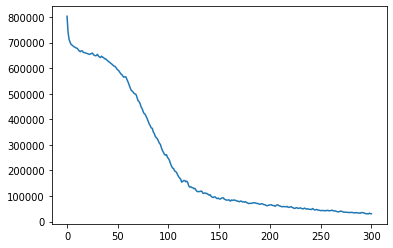

In [ ]:
plt.rcParams["figure.figsize"] = (6, 4)
plt.plot(ELBOs)

0.9948803204839498


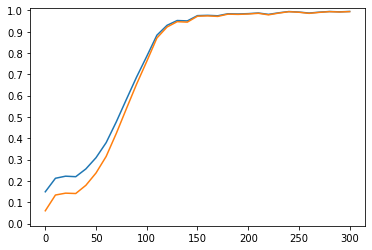

In [ ]:
plt.rcParams["figure.figsize"] = (6, 4)
plt.plot(np.arange(len(Rec_Acc)) * 10, Rec_Acc)
plt.plot(np.arange(len(Rec_Acc_remove_gap)) * 10, Rec_Acc_remove_gap)
plt.ylim(-0.01, 1.01)
plt.yticks(np.arange(0, 1.01, 0.1))
print(max(Rec_Acc_remove_gap[1:]))

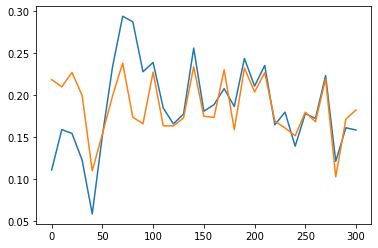

In [ ]:
plt.rcParams["figure.figsize"] = (6, 4)
plt.plot(np.arange(len(train_corr)) * 10, train_corr)
plt.plot(np.arange(len(test_corr)) * 10, test_corr)
plt.show()

spearmanr:  0.1579660093315512
pearson:  0.2596248776191071


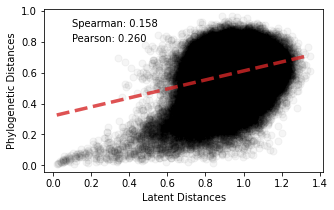

In [ ]:
# Distances Correlation


S_onehot = torch.zeros_like(S_train[:, :, None]).expand([-1, -1, 24]).clone().scatter_(-1, S_train[:, :, None], 1)
MSA = S_onehot[:, :, :].float().cuda()
Z_loc = vae.encoder(MSA, None).detach()
latent_distance = 1 - torch.sum(Z_loc[None, :, :] * Z_loc[:, None, :], dim=-1) / torch.norm(Z_loc, p=2, dim=-1)[None, :] / torch.norm(Z_loc, p=2, dim=-1)[:, None]
latent_distance_upper = latent_distance[torch.triu_indices(S_train.shape[0], S_train.shape[0], 1)[0], torch.triu_indices(S_train.shape[0], S_train.shape[0], 1)[1]]
real_distance_upper = true_tree_distances_train[torch.triu_indices(S_train.shape[0], S_train.shape[0], 1)[0], torch.triu_indices(S_train.shape[0], S_train.shape[0], 1)[1]]


print("spearmanr: ", spearmanr(latent_distance_upper.cpu(), real_distance_upper)[0])
print("pearson: ", pearsonr(latent_distance_upper.cpu(), real_distance_upper)[0])

parameter = np.polyfit(latent_distance_upper.cpu(), real_distance_upper, 1)
x = np.arange(min(latent_distance_upper.cpu()), max(latent_distance_upper.cpu()), 0.1)
y = parameter[0] * x + parameter[1]

plt.rcParams["figure.figsize"] = (5, 3)
plt.xlabel("Latent Distances")
plt.ylabel("Phylogenetic Distances")
plt.text(0.1, 0.9, "Spearman: %.3f"% spearmanr(latent_distance_upper.cpu(), real_distance_upper)[0])
plt.text(0.1, .8, "Pearson: %.3f"% pearsonr(latent_distance_upper.cpu(), real_distance_upper)[0])
plt.scatter(latent_distance_upper.cpu(), real_distance_upper, alpha=0.04, s=50, color="black")
# plt.xlim(0, 5.5)
# plt.ylim(-0.5, 4.0)
plt.plot(x, y, color="tab:red", linewidth=3.5, alpha=0.8, linestyle="--")

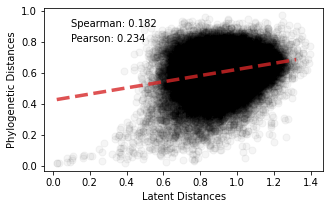

In [ ]:
S_onehot = torch.zeros_like(S_test[:, :, None]).expand([-1, -1, 24]).clone().scatter_(-1, S_test[:, :, None], 1)
MSA = S_onehot[:, :, :].float().cuda()
Z_loc = vae.encoder(MSA, None).detach()
latent_distance = 1 - torch.sum(Z_loc[None, :, :] * Z_loc[:, None, :], dim=-1) / torch.norm(Z_loc, p=2, dim=-1)[None, :] / torch.norm(Z_loc, p=2, dim=-1)[:, None]
latent_distance_upper = latent_distance[torch.triu_indices(S_test.shape[0], S_test.shape[0], 1)[0], torch.triu_indices(S_test.shape[0], S_test.shape[0], 1)[1]]
real_distance_upper = true_tree_distances_test[torch.triu_indices(S_test.shape[0], S_test.shape[0], 1)[0], torch.triu_indices(S_test.shape[0], S_test.shape[0], 1)[1]]


parameter = np.polyfit(latent_distance_upper.cpu(), real_distance_upper, 1)
x = np.arange(min(latent_distance_upper.cpu()), max(latent_distance_upper.cpu()), 0.1)
y = parameter[0] * x + parameter[1]

plt.rcParams["figure.figsize"] = (5, 3)
plt.xlabel("Latent Distances")
plt.ylabel("Phylogenetic Distances")
plt.text(0.1, .9, "Spearman: %.3f"% spearmanr(latent_distance_upper.cpu(), real_distance_upper)[0])
plt.text(0.1, .8, "Pearson: %.3f"% pearsonr(latent_distance_upper.cpu(), real_distance_upper)[0])
plt.scatter(latent_distance_upper.cpu(), real_distance_upper, alpha=0.04, s=50, color="black")

# plt.xticks([0, 1, 2, 3, 4])
plt.plot(x, y, color="tab:red", linewidth=3.5, alpha=.8, linestyle="--")

In [ ]:
pyro.param("sigma_f_loc"), pyro.param("sigma_n_loc"), pyro.param("lambd_loc")

(tensor([1.9097, 1.8134, 1.9838, 1.9867, 1.9374, 1.9261, 1.9110, 1.9633, 1.9874,
         1.8827, 1.8525, 1.9103, 1.8623, 1.8472, 1.9728, 1.9935, 1.9242, 2.0131,
         1.8528, 1.9653, 1.8207, 1.8902, 2.0025, 2.0104, 2.0194, 2.0042, 1.9702,
         1.9538, 1.8394, 1.9075, 1.8260, 1.8279, 1.9286, 1.8364, 1.8211, 1.9240,
         1.9513, 1.9101, 1.8287, 1.9264, 1.8776, 1.8473, 2.0418, 1.8116, 1.8172,
         1.8503, 1.9817, 1.9117, 1.8596, 2.1292, 1.8777, 1.8762, 1.8143, 1.8901,
         1.8270, 1.9342, 1.9684, 1.9425, 1.9293, 1.9729, 1.8813, 2.0388, 1.8206,
         1.9505, 1.9967, 1.9440, 1.8209, 1.8633, 1.8843, 1.9773, 1.8332, 1.8863,
         2.0718, 1.8337, 2.0209, 1.8679, 1.9209, 1.9393, 1.9658, 1.8562, 1.9450,
         1.8416, 1.9756, 1.9443, 1.8541, 1.8680, 1.9876, 1.9348, 1.8929, 1.8869,
         2.0201, 2.0648, 1.9506, 1.9836, 1.8675, 1.8114, 1.8240, 1.8780, 1.9442,
         2.0193], device='cuda:0', grad_fn=<AddBackward0>),
 tensor([0.1728, 0.1369, 0.1724, 0.1729, 0.1640, 